# Instituto Tecnológico de Santo Domingo
## Aplicaciones de los Métodos de Optimización Cuasi-Newton en Aprendizaje Profundo

Considerar un problema de optimizacion no restringido con la funcion multimodal de Himmelblau de 2 dimensiones $f(x)$: $\mathbb{R}$ → $\mathbb{R}$

\begin{equation}
\begin{aligned}
\min_{x} \quad & (x_1^2 + x_2 - 11)^2  + (x_1 + x_2^2 - 7)^2\\
\end{aligned}
\end{equation}

Gradiente de $f(x)$:

$$\nabla f(x) =\begin{bmatrix}
2 x_1 + 4x_1 (x_1^2 + x_2 - 11) + 2x_2^2 - 14\\
2x_2 + 4x_2 (x_2^2 + x_1 - 7)+ 2x_1^2 - 22\\
\end{bmatrix}$$

Existen 9 posibles resultados de minimos, entre los cuales se encuentran:
$$ x=[3, 2]$$
$$ x=[3.39, 0.07]$$
$$ x=[-2.81, 3.13]$$
$$ x=[3.58, -1.84]$$
$$ x=[-3.07, -0.08]$$

In [1]:
import numpy as np
import numpy.linalg as ln
import scipy as sp
import scipy.optimize

# Funcion objetivo
def f(x):
    return (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2 # funcion objetivo

# Gradiente de funcion objetivo
def f1(x):
    return np.array([2*x[0] + 4*x[0] * (x[0]**2 + x[1] - 11) + 2*x[1]**2 - 14,
                    2*x[1] + 4*x[1] * (x[1]**2 + x[0] - 7) + 2*x[0]**2 - 22]) # gradiente de la funcion


<Figure size 432x288 with 0 Axes>

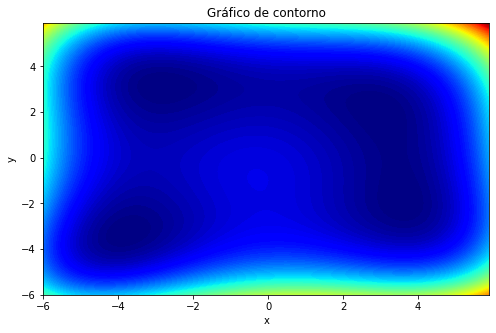

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
fig, axes = plt.subplots(1,1, sharey=True, figsize=(8,5))
#ax = Axes3D(fig, azim = -29, elev = 49)
X = np.arange(-6, 6, 0.1)
Y = np.arange(-6, 6, 0.1)
X, Y = np.meshgrid(X, Y)
Z = (X*X+Y-11)**2 + (X+Y*Y-7)**2
#ax.plot_surface(X, Y, Z, rstride = 1, cstride = 1, norm = LogNorm(), cmap = cm.jet)
axes.contourf(X, Y, Z, levels=100, cmap = cm.jet)
plt.title('Gráfico de contorno')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### Metodo BFGS

In [4]:
'''
    Referencias: https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm
    https://habr.com/ru/post/333356/

Consultado el PseudoCodigo del Metodo:
- CG, BFGS and SR1 4.1 Project descriptions - UCI Canvas
'''

def metodo_bfgs(f, fprime, x0, 
                maxiter=1000, epsi=10e-3):
    """
    Minimizar una función f usando el algoritmo BFGS.
    
    Parámetros
    ----------
    f : f(x)
        Función a minimizar.
    x0 : ndarray
        Estimación inicial.
    fprime : fprime(x)
        El gradiente de `func`.
    """

    # valores iniciales
    k = 0
    gfk = fprime(x0)
    N = len(x0)
    # Matriz de identidad para inicializar h_k
    I = np.eye(N, dtype=int)
    Hk = I
    xk = x0
    xk_vect = [xk]
    alpha_k_list = []
    while ln.norm(gfk) > epsi and k < maxiter: #Criterios de convergencia
        
        # pk - Direccion de busqueda
        pk = -np.dot(Hk, gfk)
        
        # Estrategia utilizada: Busqueda de linea
        # Búsqueda de línea para las condiciones de Wolfe
        line_search = sp.optimize.line_search(f, f1, xk, pk, maxiter=500)
        #alpha_k - Tamaño del paso
        alpha_k = line_search[0]
        #alpha_k = 0.05
        
        xkp1 = xk + alpha_k * pk
        sk = xkp1 - xk
        xk = xkp1
        
        gfkp1 = fprime(xkp1)
        yk = gfkp1 - gfk
        gfk = gfkp1
        
        k += 1
        
        ro = 1.0 / (np.dot(yk, sk))
        A1 = I - ro * sk[:, np.newaxis] * yk[np.newaxis, :]
        A2 = I - ro * yk[:, np.newaxis] * sk[np.newaxis, :]
        Hk = np.dot(A1, np.dot(Hk, A2)) + (ro * sk[:, np.newaxis] *
                                                sk[np.newaxis, :]) #H_{k+1}
        alpha_k_list.append(alpha_k) # Guardar listado de alphas usados
        xk_vect.append(xk)# Guardar listado de puntos obtenidos para el grafico

    return (xk_vect, k, alpha_k_list[-5:]) #retornar ultimos 5 alphas

punto_inicial = np.array([1.80, -3.36])
result_bfgs, k_bfgs, alpha_k_bfgs = metodo_bfgs(f, f1, punto_inicial, maxiter=5000)

print('Resultado del metodo BFGS:')
print('Resultado final (minimizacion): %s' % (result_bfgs[-1]))
print('Conteo de iteraciones: %s' % (k_bfgs))
print('Ultimos 5 valores de alpha_k optimos que satisfacen condiciones Wolfe: %s' % (alpha_k_bfgs))

Resultado del metodo BFGS:
Resultado final (minimizacion): [3.0000129  1.99989823]
Conteo de iteraciones: 8
Ultimos 5 valores de alpha_k optimos que satisfacen condiciones Wolfe: [0.55533583416922, 0.4127526911544688, 1.0, 1.0, 1.0]


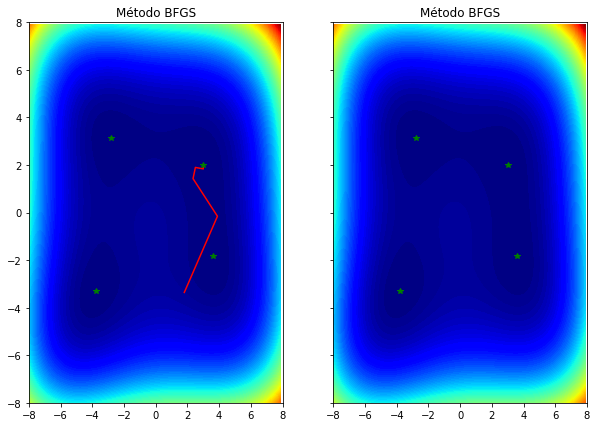

In [5]:
# gráfico de contorno lleno para la función objetivo 2d y mostrar los óptimos
from numpy import arange, meshgrid
import matplotlib.cm as cm
import matplotlib.pyplot as plt

def return_appropriate_result_column(list_of_lists):
    '''
    Funcion que retorna una lista de listas segun puntos resultado del metodo.
    '''
    xvect = [row[0] for row in list_of_lists]
    yvect = [row[1] for row in list_of_lists]
    return [xvect, yvect]

# definir el rango del input
r_min, r_max = -8.0, 8
# rango de entrada de muestra uniformemente en incrementos de 0.1
xaxis = arange(r_min, r_max, 0.1)
yaxis = arange(r_min, r_max, 0.1)
# crear una malla a partir del eje
x, y = meshgrid(xaxis, yaxis)
# computar objetivos
results = f([x, y])

# definir set de pasos tomados para llegar al optimo
optima_x = return_appropriate_result_column(result_bfgs)

method = 'BFGS'
fig, axes = plt.subplots(1,2, sharey=True, figsize=(10,7))
for ax, zord in zip(axes, [1,-1]):
    # crear un gráfico de contorno lleno con 100 niveles y un esquema de color jet
    ax.contourf(x, y, results, levels=100, cmap='jet')
    ax.autoscale(False) # Para evitar que cambios de límite    
    ax.plot(optima_x[0], optima_x[1], zorder=zord, color='red')
    ax.plot(3, 2, '*', color='green') # Punto de optimos 1
    ax.plot(3.5844, -1.8481, '*', color='green') # Punto de optimos 2
    ax.plot(-3.77931025, -3.28318599, '*', color='green') # Punto de optimos 3
    ax.plot(-2.805118, 3.1313125, '*', color='green') # Punto de optimos 4
    ax.set_title('Método {0}'.format(method))
    ax.set_xlim(r_min, r_max)
    ax.set_ylim(r_min, r_max)

### Metodo SR1

In [6]:
'''
Consultado el PseudoCodigo del Metodo: 
- CG, BFGS and SR1 4.1 Project descriptions - UCI Canvas
'''

def metodo_sr1(f, fprime, x0,
               maxiter=None, epsi=10e-3):
    '''
    Implementacion del metodo cuasi-Newton SR1 (Symmetric Rank 1)
    '''

    # valores iniciales
    k = 0
    gfk = fprime(x0)
    N = len(x0)
    # matriz de identidad para inicializar p_k
    I = np.eye(N, dtype=int) 
    Hk = I # Inicializar Hk con la matriz identidad de tamaño N
    xk = x0
    alpha_k_list = []
    xk_vect = [xk]
    while ln.norm(gfk) > epsi and k < maxiter: #Criterios de convergencia
        
        # pk - Direccion de busqueda
        pk = -np.dot(Hk, gfk)
        
        #LINE SEARCH
        # Constantes de búsqueda de línea para las condiciones de Wolfe.
        line_search = sp.optimize.line_search(f, f1, xk, pk, maxiter=500)
        # alpha_k - Tamaño del paso
        alpha_k = line_search[0]
        #alpha_k = 0.025 
        
        xkp1 = xk + alpha_k * pk
        sk = xkp1 - xk
        xk = xkp1
        
        gfkp1 = fprime(xkp1)
        yk = gfkp1 - gfk
        gfk = gfkp1
        
        k += 1

        A1 = np.dot(Hk, yk) - sk
        Hk = Hk - (np.dot(A1[:, np.newaxis], A1[np.newaxis, :])/np.dot(A1[np.newaxis, :], yk))
        alpha_k_list.append(alpha_k) # Guardar listado de alphas usados
        xk_vect.append(xk) # Guardar listado de puntos obtenidos para el grafico

    return (xk_vect, k, alpha_k_list[-5:])

punto_inicial = np.array([1.80, -3.36])
result_sr1, k_sr1, alpha_k_sr1 = metodo_sr1(f, f1, punto_inicial, maxiter=5000)

print('Resultado del metodo SR1:')
print('Resultado final (minimizacion): %s' % (result_sr1[-1]))
print('Conteo de iteraciones: %s' % (k_sr1))
print('Ultimos 5 valores de alpha_k optimos que satisfacen condiciones Wolfe: %s' % (alpha_k_sr1))

Resultado del metodo SR1:
Resultado final (minimizacion): [3.00000363 1.99999372]
Conteo de iteraciones: 9
Ultimos 5 valores de alpha_k optimos que satisfacen condiciones Wolfe: [1.0, 1.0, 0.15975092214104447, 1.0, 1.0]


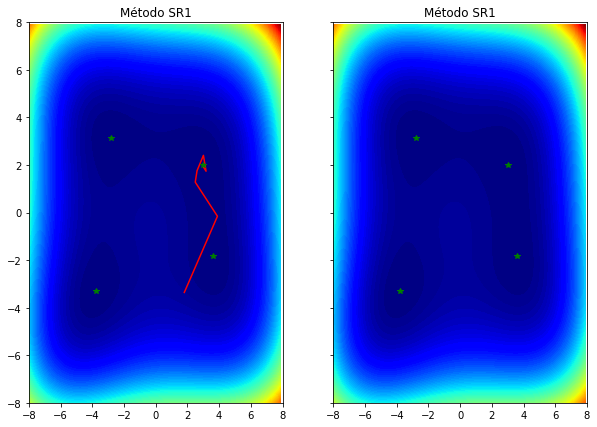

In [7]:
# definir set de pasos tomados para llegar al optimo
optima_x = return_appropriate_result_column(result_sr1) #Resultados de SR1 aplicados a la funcion

method = 'SR1'
fig, axes = plt.subplots(1,2, sharey=True, figsize=(10,7))
for ax, zord in zip(axes, [1,-1]):
    # crear un gráfico de contorno lleno con 100 niveles y un esquema de color jet
    ax.contourf(x, y, results, levels=100, cmap='jet')
    ax.autoscale(False) # Para evitar que cambios de límite    
    ax.plot(optima_x[0], optima_x[1], zorder=zord, color='red')
    ax.plot(3, 2, '*', color='green') # Punto de optimos 1
    ax.plot(3.5844, -1.8481, '*', color='green') # Punto de optimos 2
    ax.plot(-3.77931025, -3.28318599, '*', color='green') # Punto de optimos 3
    ax.plot(-2.805118, 3.1313125, '*', color='green') # Punto de optimos 4
    ax.set_title('Método {0}'.format(method))
    ax.set_xlim(r_min, r_max)
    ax.set_ylim(r_min, r_max)

### Metodo de Newton

In [8]:
def hessian_function(x):
    '''
    Predefinir el hessiano de la funcion.
    '''
    return np.array([[12*x[0]**2+4*x[1]-42, 4*x[0]+4*x[1]], 
                     [4*x[0]+4*x[1],        12*x[1]**2+4*x[0]-26]])


def metodo_newton(f, fprime, hessian,
                  x0, maxiter=5000, epsi=10e-3):
    '''
    Implementacion del metodo de Newton-Raphson.
    '''
    
    k = 0 # Iniciar conteo de iteraciones
    gfk = fprime(x0) #jacobiano
    Hk = hessian(x0) #hessiano
    xk = x0
    xk_vect = [xk]
    S = np.linalg.inv(Hk) # Direccion de busqueda

    while ln.norm(gfk) > epsi or k < maxiter:
        
        xk = xk - np.dot(S, gfk)
        k+=1
        xk_vect.append(xk)
        gfk = fprime(xk)
        Hk = hessian(xk)
        S = np.linalg.inv(Hk)

    return xk_vect, k

punto_inicial = np.array([1.80, -3.36])
#punto_inicial = np.array([2,2]) #set de puntos iniciales
result_newton, k_newton = metodo_newton(f, f1, hessian_function, punto_inicial)

print('Resultado del metodo de Newton:')
print('Resultado final (minimizacion): %s' % (result_newton[-1]))
print('Conteo de iteraciones: %s' % (k_newton))

Resultado del metodo de Newton:
Resultado final (minimizacion): [-3.77931025 -3.28318599]
Conteo de iteraciones: 5000


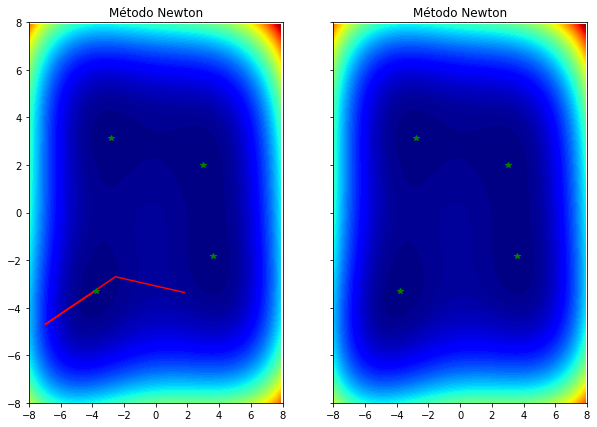

In [9]:
optima_x = return_appropriate_result_column(result_newton) #Resultados de Newton aplicados a la funcion

method = 'Newton'
fig, axes = plt.subplots(1,2, sharey=True, figsize=(10,7))
for ax, zord in zip(axes, [1,-1]):
    # crear un gráfico de contorno lleno con 100 niveles y un esquema de color jet
    ax.contourf(x, y, results, levels=100, cmap='jet')
    ax.autoscale(False) # Para evitar que cambios de límite    
    ax.plot(optima_x[0], optima_x[1], zorder=zord, color='red')
    ax.plot(3, 2, '*', color='green') # Punto de optimos 1
    ax.plot(3.5844, -1.8481, '*', color='green') # Punto de optimos 2
    ax.plot(-3.77931025, -3.28318599, '*', color='green') # Punto de optimos 3
    ax.plot(-2.805118, 3.1313125, '*', color='green') # Punto de optimos 4
    ax.set_title('Método {0}'.format(method))
    ax.set_xlim(r_min, r_max)
    ax.set_ylim(r_min, r_max)

Este metodo es mas sensible al punto inicial que los demas metodos. Se observa como el metodo se acerca a otro de los minimos validos, sin converger al nivel indicado (epsilon) luego de 5,000 iteraciones.

### Metodo de descenso de gradiente

In [10]:
def metodo_gradient_descent(f, fprime, x0,
                            maxiter=5000, epsi=10e-3):
    '''
    Implementacion del metodo del maximo descenso.
    '''
    k = 0 # Iniciar conteo de iteraciones
    gfk = fprime(x0)
    xk = x0
    xk_vect = [xk]
    alpha = 0.01 #alpha busqueda de linea fijo
    while ln.norm(gfk) > epsi or k < maxiter:
        xk = xk - alpha * gfk
        k+=1
        xk_vect.append(xk)
        gfk = fprime(xk)
    return xk_vect, k

punto_inicial = np.array([1.80, -3.36])
#punto_inicial = np.array([-6,0])
result_GD, k_GD = metodo_gradient_descent(f, f1, punto_inicial)

print('Resultado del metodo de GD:')
print('Resultado final (minimizacion): %s' % (result_GD[-1]))
print('Conteo de iteraciones: %s' % (k_GD))

Resultado del metodo de GD:
Resultado final (minimizacion): [ 3.58442834 -1.84812653]
Conteo de iteraciones: 5000


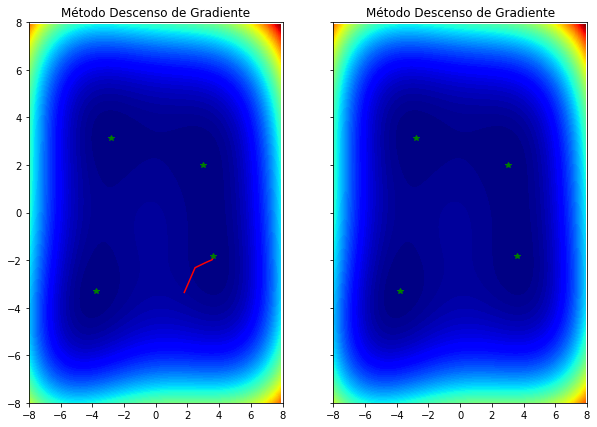

In [11]:
optima_x = return_appropriate_result_column(result_GD) #Resultados de GD aplicados a la funcion

method = 'Descenso de Gradiente'
fig, axes = plt.subplots(1,2, sharey=True, figsize=(10,7))
for ax, zord in zip(axes, [1,-1]):
    # crear un gráfico de contorno lleno con 100 niveles y un esquema de color jet
    ax.contourf(x, y, results, levels=100, cmap='jet')
    ax.autoscale(False) # Para evitar que cambios de límite
    ax.plot(optima_x[0], optima_x[1], zorder=zord, color='red')
    ax.plot(3, 2, '*', color='green') # Punto de optimos 1
    ax.plot(3.5844, -1.8481, '*', color='green') # Punto de optimos 2
    ax.plot(-3.77931025, -3.28318599, '*', color='green') # Punto de optimos 3
    ax.plot(-2.805118, 3.1313125, '*', color='green') # Punto de optimos 4
    ax.set_title('Método {0}'.format(method))
    ax.set_xlim(r_min, r_max)
    ax.set_ylim(r_min, r_max)

A este metodo le cuesta mucho mas lograr converger al mismo nivel de epsilon indicado, ademas de ser sensible al punto inicial.

# Aplicaciones en redes neuronales

Introduccion al problema de clasificacion del dataset `cifar`: https://www.cs.toronto.edu/~kriz/cifar.html.

Primero probamos con `Adam`.
Consultado el workaround de la aplicacion de L-BFGS con `TensorFlow  Probability`: https://pychao.com/2019/11/02/optimize-tensorflow-keras-models-with-l-bfgs-from-tensorflow-probability/

In [12]:
#https://marcinbogdanski.github.io/ai-sketchpad/KerasNN/1100_CNN_CIFAR10.html

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, InputLayer
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import tensorflow.keras.layers as tfl

In [13]:
#from google.colab import drive
#drive.mount('/content/drive') #conectar google drive
#import h5py

# define location of dataset
#file1 = '/content/drive/MyDrive/INTEC/Data Tesis/Train'
#file2 = '/content/drive/MyDrive/INTEC/Data Tesis/test_signs.h5'

#X_train_orig = h5py.File(file1, mode='r')

In [14]:
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = tf.keras.datasets.cifar10.load_data()
class2txt = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=[16, 9])
for i in range(len(axes)):
    axes[i].set_title(class2txt[y_train_raw[i, 0]]) #mostrar el titulo del tag
    axes[i].imshow(x_train_raw[i]) #mostrar la foto de la clase 

In [ ]:
#Normalizar entradas
x_train = (x_train_raw - x_train_raw.mean()) / x_train_raw.std()
x_test = (x_test_raw - x_train_raw.mean()) / x_train_raw.std()

#One-Hot Encoding
y_train = tf.keras.utils.to_categorical(y_train_raw, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test_raw, num_classes=10)
print('y_train.shape', y_train.shape)
print(y_train[:3])

In [ ]:
X_input = Input(shape=[32, 32, 3])

X = Conv2D(filters=16, kernel_size=3, padding='same', activation='elu')(X_input)
X = MaxPooling2D(pool_size=[2,2], strides=[2, 2], padding='same')(X)

X = Conv2D(filters=32, kernel_size=3, padding='same', activation='elu')(X)
X = MaxPooling2D(pool_size=[2,2], strides=[2, 2], padding='same')(X)

X = Conv2D(filters=64, kernel_size=3, padding='same', activation='elu')(X)
X = MaxPooling2D(pool_size=[2,2], strides=[2, 2], padding='same')(X)

X = Flatten()(X)
X = Dropout(0.2)(X)

X = Dense(512, activation='elu')(X)
X = Dropout(0.2)(X)

X = Dense(10, activation='softmax')(X)

model = tf.keras.Model(inputs=X_input, outputs=X)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
#Entrenar modelo con Adam
hist = model.fit(x=x_train, y=y_train, batch_size=250,
                 epochs=100, validation_data=(x_test, y_test), verbose=2)

In [ ]:
#imprimir loss y accuracy
loss, acc = model.evaluate(x_train, y_train, batch_size=250, verbose=0)
print(f'Accuracy on train set: {acc:.3f}')
loss, acc = model.evaluate(x_test, y_test, batch_size=250, verbose=0)
print(f'Accuracy on test set:  {acc:.3f}')

#imprimir resultados
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[16, 6])
axes[0].plot(hist.history['loss'], label='train_loss')
axes[0].plot(hist.history['val_loss'], label='val_loss')
axes[0].set_title('Perdida')
axes[0].legend()
axes[1].plot(hist.history['accuracy'], label='train_acc')
axes[1].plot(hist.history['val_accuracy'], label='val_acc')
axes[1].set_title('Precision')
axes[1].legend()

Vemos que hay un problema de overfitting ya que el modelo no generaliza en el validation set. 

## MNIST Dataset

In [1]:
#!pip install tensorflow
# keras imports for the dataset and building our neural network

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils
from keras.datasets import mnist 

# loading the dataset 
(X_train, y_train), (X_test, y_test) = mnist.load_data() 
# Flattening the images from the 28x28 pixels to 1D 787 pixels
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalizing the data to help with the training
X_train /= 255
X_test /= 255

# one-hot encoding using keras' numpy-related utilities
n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

# building a linear stack of layers with the sequential model
model = Sequential()
# hidden layer
model.add(Dense(100, input_shape=(784,), activation='relu'))
# output layer
model.add(Dense(10, activation='softmax'))

# looking at the model summary
model.summary()

Shape before one-hot encoding:  (60000,)
Shape after one-hot encoding:  (60000, 10)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [8]:
# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='Adam') #SGD / RMSprop / Adadelta / Adagrad / Adam / Adamax / Ftrl / Nadam
# training the model for 100 epochs
hist = model.fit(X_train, Y_train, batch_size=1000, epochs=100, validation_data=(X_test, Y_test))

Epoch 1/100
60/60 [==============================] - 1s 12ms/step - loss: 2.7278e-05 - accuracy: 1.0000 - val_loss: 0.1501 - val_accuracy: 0.9773
Epoch 2/100
60/60 [==============================] - 1s 10ms/step - loss: 2.3915e-05 - accuracy: 1.0000 - val_loss: 0.1516 - val_accuracy: 0.9771
Epoch 3/100
60/60 [==============================] - 1s 10ms/step - loss: 3.8018e-05 - accuracy: 1.0000 - val_loss: 0.1598 - val_accuracy: 0.9755
Epoch 4/100
60/60 [==============================] - 1s 10ms/step - loss: 9.8103e-04 - accuracy: 0.9998 - val_loss: 0.1743 - val_accuracy: 0.9745
Epoch 5/100
60/60 [==============================] - 1s 10ms/step - loss: 9.3204e-04 - accuracy: 0.9997 - val_loss: 0.1658 - val_accuracy: 0.9754
Epoch 6/100
60/60 [==============================] - 1s 11ms/step - loss: 2.6688e-04 - accuracy: 0.9999 - val_loss: 0.1604 - val_accuracy: 0.9759
Epoch 7/100
60/60 [==============================] - 1s 10ms/step - loss: 5.4141e-05 - accuracy: 1.0000 - val_loss: 0.1595 -

## Graficos de validacion: Adam



Loss on train set: 0.0000
Loss on test set:  0.1666


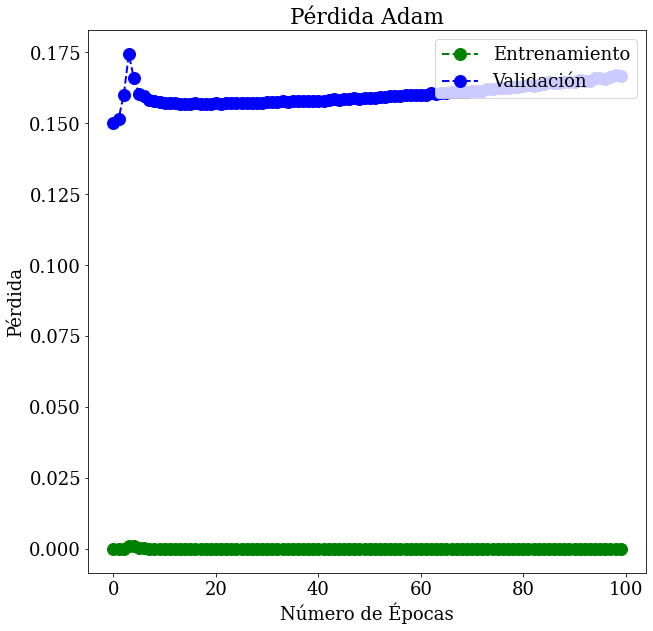

In [9]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 18})
plt.rc('font', family='serif')
plt.style.use('seaborn-muted')

#imprimir loss y accuracy
loss, acc = model.evaluate(X_train, Y_train, batch_size=1000, verbose=0)
print(f'Loss on train set: {loss:.4f}')
loss, acc = model.evaluate(X_test, Y_test, batch_size=1000, verbose=0)
print(f'Loss on test set:  {loss:.4f}')

maxiter=100 # Maximo numero de iteraciones establecido anteriormente

plt.subplots(figsize = (10, 10))
plt.plot(hist.history['loss'],
         color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)
plt.plot(hist.history['val_loss'],
         color='blue', marker='o', linestyle='dashed', linewidth=2, markersize=12)

plt.yscale("linear")
plt.title('Pérdida Adam', fontweight='normal')
plt.ylabel('Pérdida')
plt.xlabel('Número de Épocas')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')

Accuracy on train set: 1.0000
Accuracy on test set:  0.9777


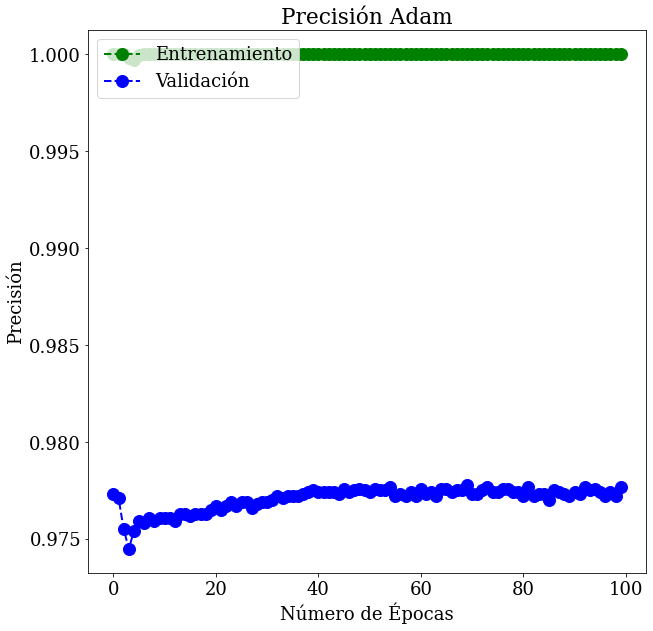

In [10]:
#imprimir loss y accuracy
loss, acc = model.evaluate(X_train, Y_train, batch_size=1000, verbose=0)
print(f'Accuracy on train set: {acc:.4f}')
loss, acc = model.evaluate(X_test, Y_test, batch_size=1000, verbose=0)
print(f'Accuracy on test set:  {acc:.4f}')

plt.subplots(figsize = (10, 10))
plt.plot(hist.history['accuracy'],
         color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)
plt.plot(hist.history['val_accuracy'],
         color='blue', marker='o', linestyle='dashed', linewidth=2, markersize=12)
plt.yscale("linear")
plt.title('Precisión Adam', fontweight='normal')
plt.ylabel('Precisión')
plt.xlabel('Número de Épocas')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

## Graficos de validacion: SGD

In [23]:
# building a linear stack of layers with the sequential model
model = Sequential()
# hidden layer
model.add(Dense(100, input_shape=(784,), activation='relu'))
# output layer
model.add(Dense(10, activation='softmax'))

In [24]:
# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='SGD') #SGD / RMSprop / Adadelta / Adagrad / Adam / Adamax / Ftrl / Nadam
# training the model for 100 epochs
hist = model.fit(X_train, Y_train, batch_size=1000, epochs=100, validation_data=(X_test, Y_test) )

Epoch 1/100
60/60 [==============================] - 1s 13ms/step - loss: 2.0675 - accuracy: 0.3462 - val_loss: 1.8083 - val_accuracy: 0.5525
Epoch 2/100
60/60 [==============================] - 1s 10ms/step - loss: 1.6319 - accuracy: 0.6294 - val_loss: 1.4312 - val_accuracy: 0.6984
Epoch 3/100
60/60 [==============================] - 1s 11ms/step - loss: 1.3116 - accuracy: 0.7256 - val_loss: 1.1602 - val_accuracy: 0.7649
Epoch 4/100
60/60 [==============================] - 1s 11ms/step - loss: 1.0886 - accuracy: 0.7729 - val_loss: 0.9769 - val_accuracy: 0.8006
Epoch 5/100
60/60 [==============================] - 1s 11ms/step - loss: 0.9367 - accuracy: 0.8028 - val_loss: 0.8513 - val_accuracy: 0.8225
Epoch 6/100
60/60 [==============================] - 1s 10ms/step - loss: 0.8300 - accuracy: 0.8206 - val_loss: 0.7612 - val_accuracy: 0.8378
Epoch 7/100
60/60 [==============================] - 1s 11ms/step - loss: 0.7520 - accuracy: 0.8332 - val_loss: 0.6941 - val_accuracy: 0.8473
Epoch 

Loss on train set: 0.2623
Loss on test set:  0.2517


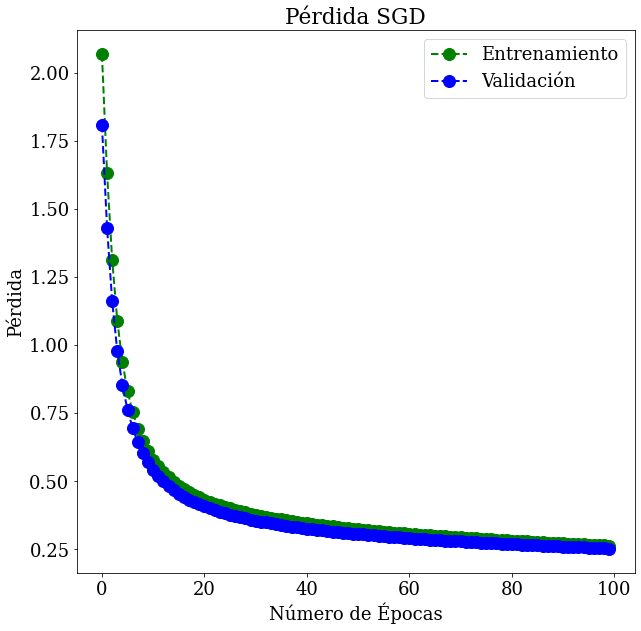

In [25]:
#imprimir loss y accuracy
loss, acc = model.evaluate(X_train, Y_train, batch_size=1000, verbose=0)
print(f'Loss on train set: {loss:.4f}')
loss, acc = model.evaluate(X_test, Y_test, batch_size=1000, verbose=0)
print(f'Loss on test set:  {loss:.4f}')

maxiter=100 # Maximo numero de iteraciones establecido anteriormente

plt.subplots(figsize = (10, 10))
plt.plot(hist.history['loss'],
         color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)
plt.plot(hist.history['val_loss'],
         color='blue', marker='o', linestyle='dashed', linewidth=2, markersize=12)

plt.yscale("linear")
plt.title('Pérdida SGD', fontweight='normal')
plt.ylabel('Pérdida')
plt.xlabel('Número de Épocas')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')

Accuracy on train set: 0.9265
Accuracy on test set:  0.9296


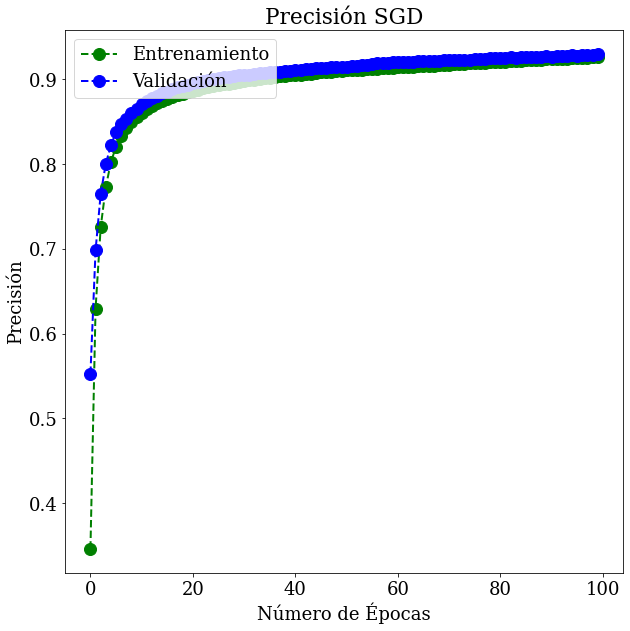

In [26]:
#imprimir loss y accuracy
loss, acc = model.evaluate(X_train, Y_train, batch_size=1000, verbose=0)
print(f'Accuracy on train set: {acc:.4f}')
loss, acc = model.evaluate(X_test, Y_test, batch_size=1000, verbose=0)
print(f'Accuracy on test set:  {acc:.4f}')

plt.subplots(figsize = (10, 10))
plt.plot(hist.history['accuracy'],
         color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)
plt.plot(hist.history['val_accuracy'],
         color='blue', marker='o', linestyle='dashed', linewidth=2, markersize=12)
plt.yscale("linear")
plt.title('Precisión SGD', fontweight='normal')
plt.ylabel('Precisión')
plt.xlabel('Número de Épocas')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')